<h1>Лабораторная работа №1<h1>
<h2>Выполнил: Щелкушкин Е.Р.<h2>
<h2>Группа: ББМО-02-22<h2/>

Клонируем репозиторий

In [1]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93
Receiving objects: 100% (96/96), 33.99 MiB | 20.72 MiB/s, done.
Resolving deltas: 100% (27/27), done.


Сменить директорию на "EEL6812_DeepFool_Project".

In [2]:
%cd EEL6812_DeepFool_Project/

/content/EEL6812_DeepFool_Project


Выполнить импорт библиотек.

In [3]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

Установим случайное рандомное значение в виде переменной rand_seed={"Порядковый номер ученика группы в Гугл-таблице"}.
Установим указанное значение для np.random.seed и torch.manual_seed.

In [4]:
rand_seed = 32 # Мой номер в списке
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

Используем в качестве устройства видеокарту (Среды выполнения--> Сменить среду выполнения --> T4 GPU).

In [5]:
rand_seed = 7
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

Загрузим датасет MNIST c параметрами mnist_mean = 0.5, mnist_std = 0.5, mnist_dim = 28.

In [6]:
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([ transforms.ToTensor( ), transforms.Normalize( mean=mnist_mean, std=mnist_std)])
mnist_tf_train = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=mnist_mean, std=mnist_std)])
mnist_tf_inv = transforms.Compose([transforms.Normalize(mean=0.0, std=np.divide(1.0, mnist_std)), transforms.Normalize(mean=np.multiply(-1.0, mnist_std), std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])
mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)

100%|██████████| 9912422/9912422 [00:00<00:00, 66460632.23it/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 93613364.62it/s]

Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32270351.95it/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20095494.48it/s]

Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



Загрузим датасет CIFAR-10 c параметрами.

In [7]:
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=cifar_mean, std=cifar_std)])
cifar_tf_train = transforms.Compose([transforms.RandomCrop(size=cifar_dim, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=cifar_mean, std=cifar_std)])
cifar_tf_inv = transforms.Compose([transforms.Normalize( mean=[0.0, 0.0, 0.0], std=np.divide(1.0,cifar_std)), transforms.Normalize(mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])
cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:03<00:00, 54671857.29it/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


Выполним настройку и загрузку DataLoader.

In [8]:
batch_size = 64
workers = 4
mnist_loader_train  = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,  num_workers=workers)
mnist_loader_val    = DataLoader(mnist_val,   batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test   = DataLoader(mnist_test,  batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_train  = DataLoader(cifar_train, batch_size=batch_size, shuffle=True,  num_workers=workers)
cifar_loader_val    = DataLoader(cifar_val,   batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test   = DataLoader(cifar_test,  batch_size=batch_size, shuffle=False, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Инициализируем deep_args

In [10]:

batch_size = 10
num_classes = 10
overshoot = 0.02
max_iters = 50
deep_args = [batch_size, num_classes, overshoot, max_iters]

Загрузим и оценим стойкость модели Network-In-Network Model к FGSM и DeepFool атакам на основе датасета CIFAR-10

In [11]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cpu')))

evaluate_attack('cifar_nin_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda': torch.cuda.empty_cache()


FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


Загрузим и оценим стойкость модели LeNet к FGSM и DeepFool атакам на основе датасета CIFAR-10.

In [12]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))

evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda': torch.cuda.empty_cache()


FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


LeNet на датасете MNIST

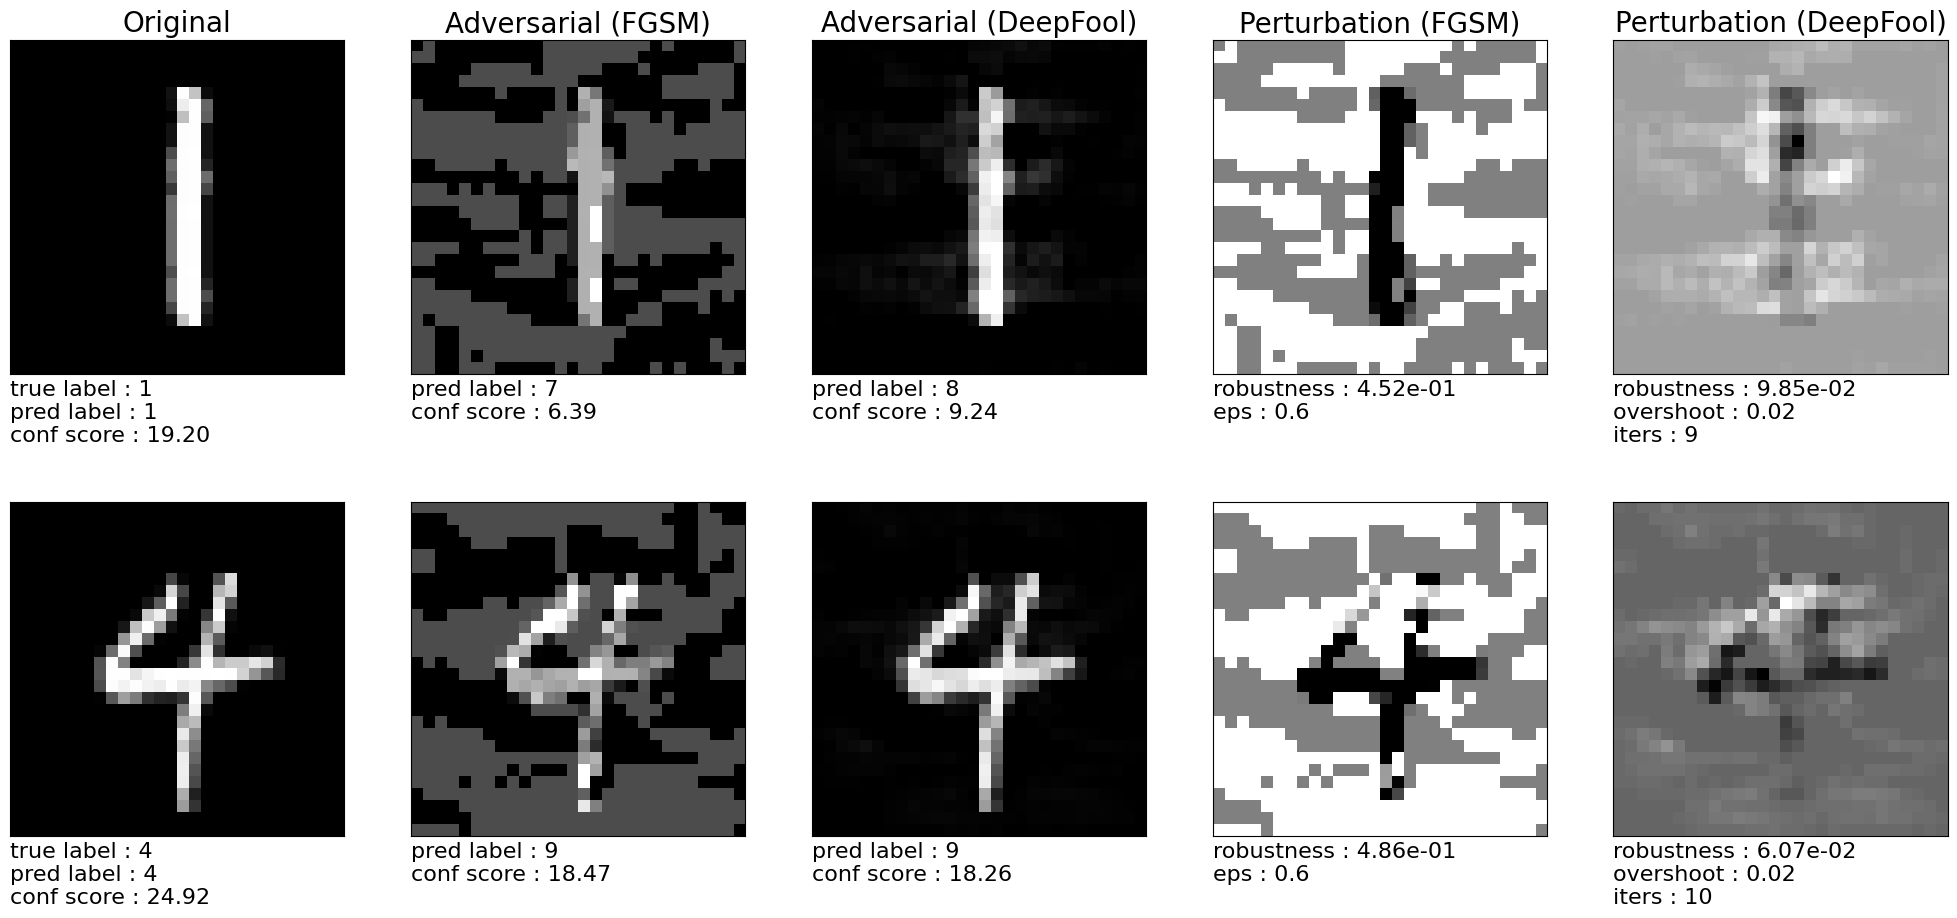

In [18]:
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', map_location=device))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

FCNet на датасете MNIST

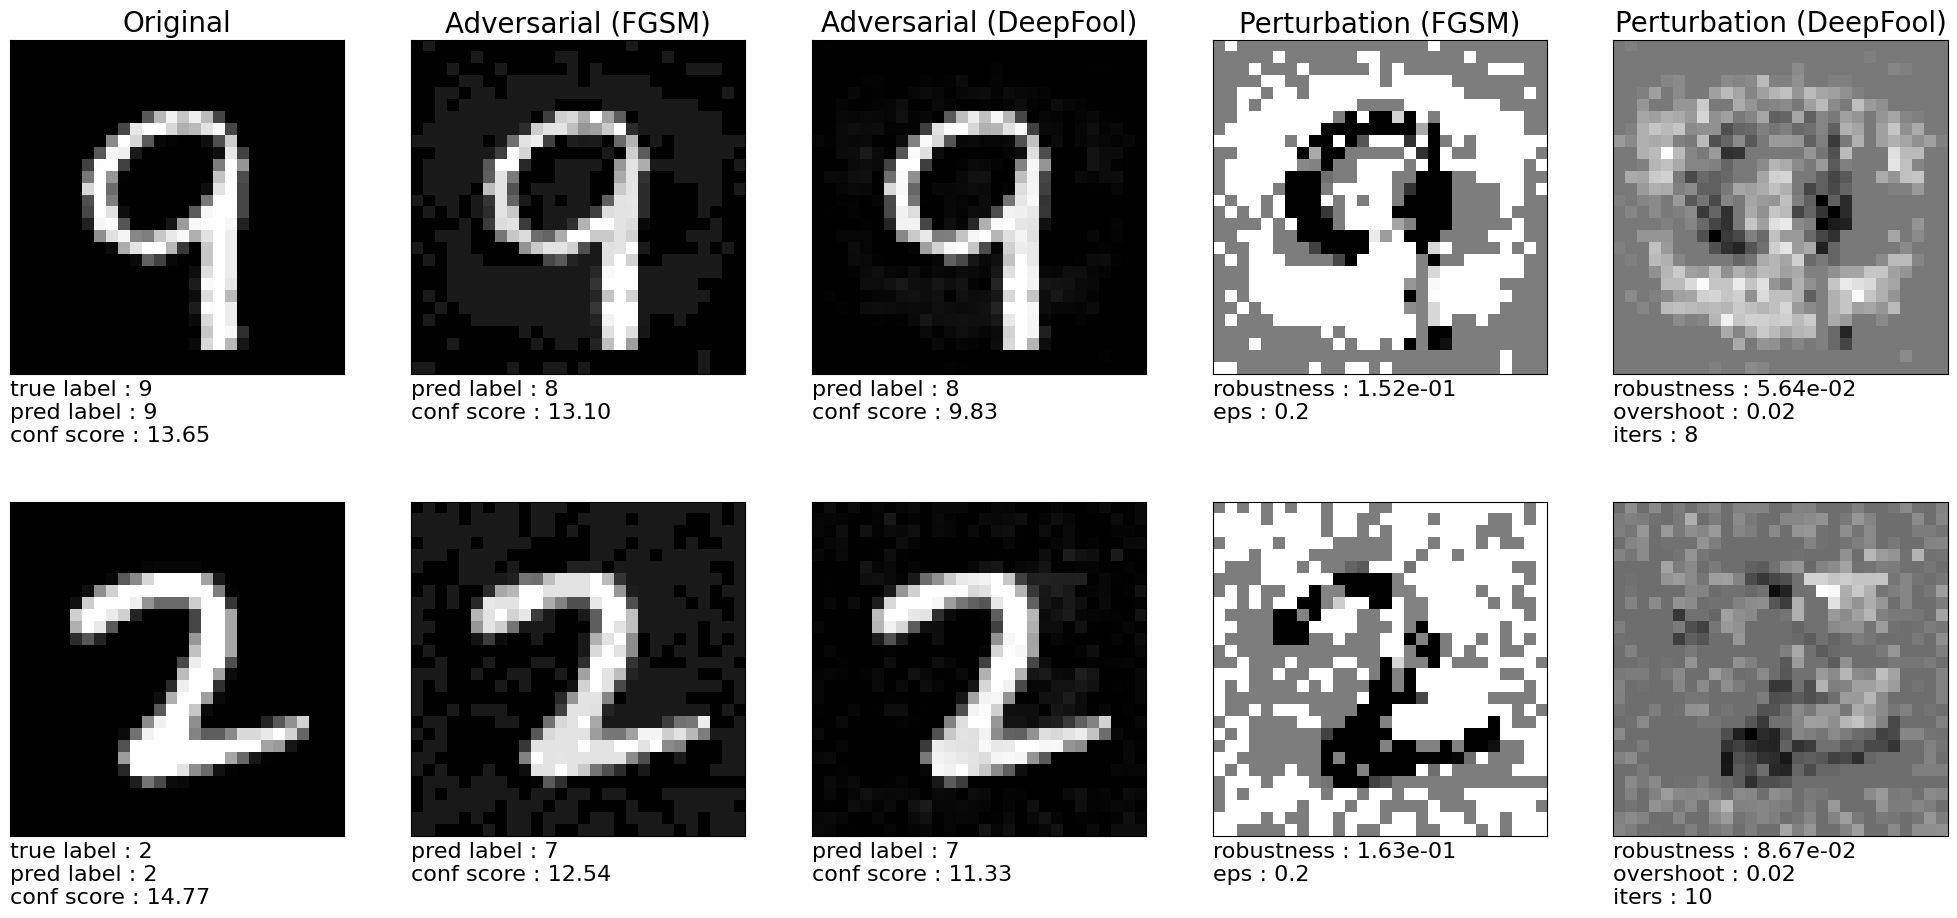

In [19]:

fgsm_eps = 0.2

model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

Network-in-Network на датасете CIFAR

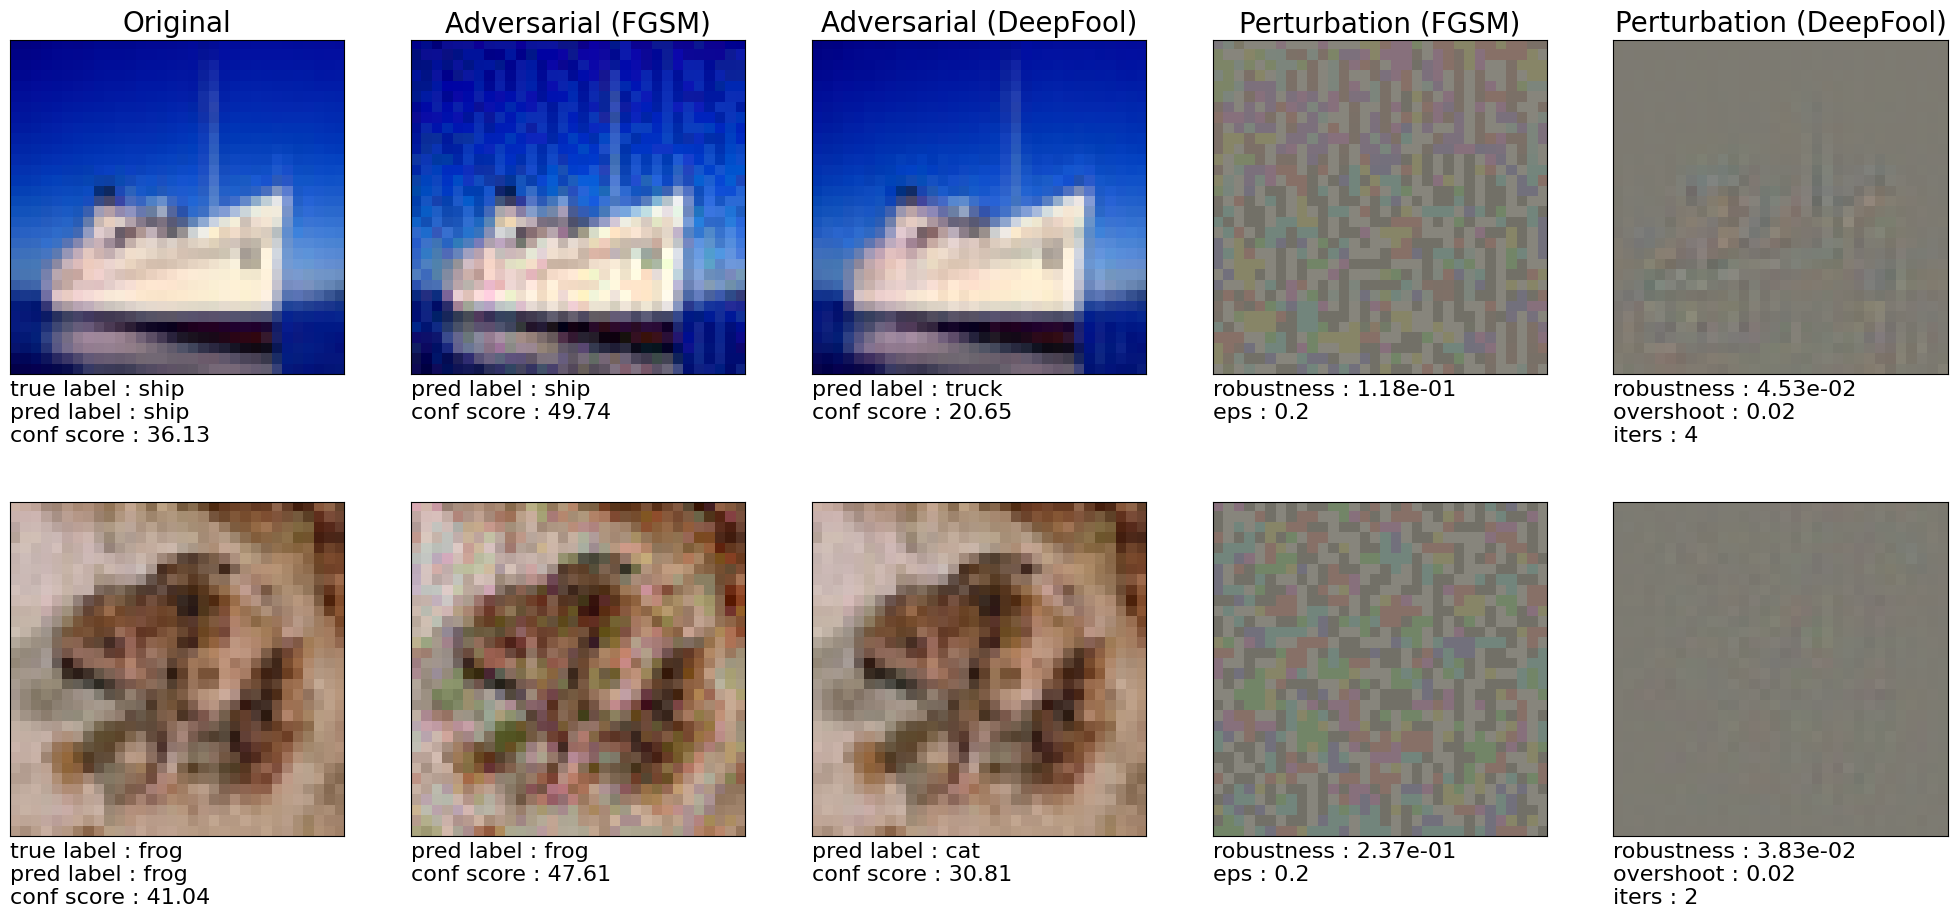

In [20]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

LeNet на датасете CIFAR

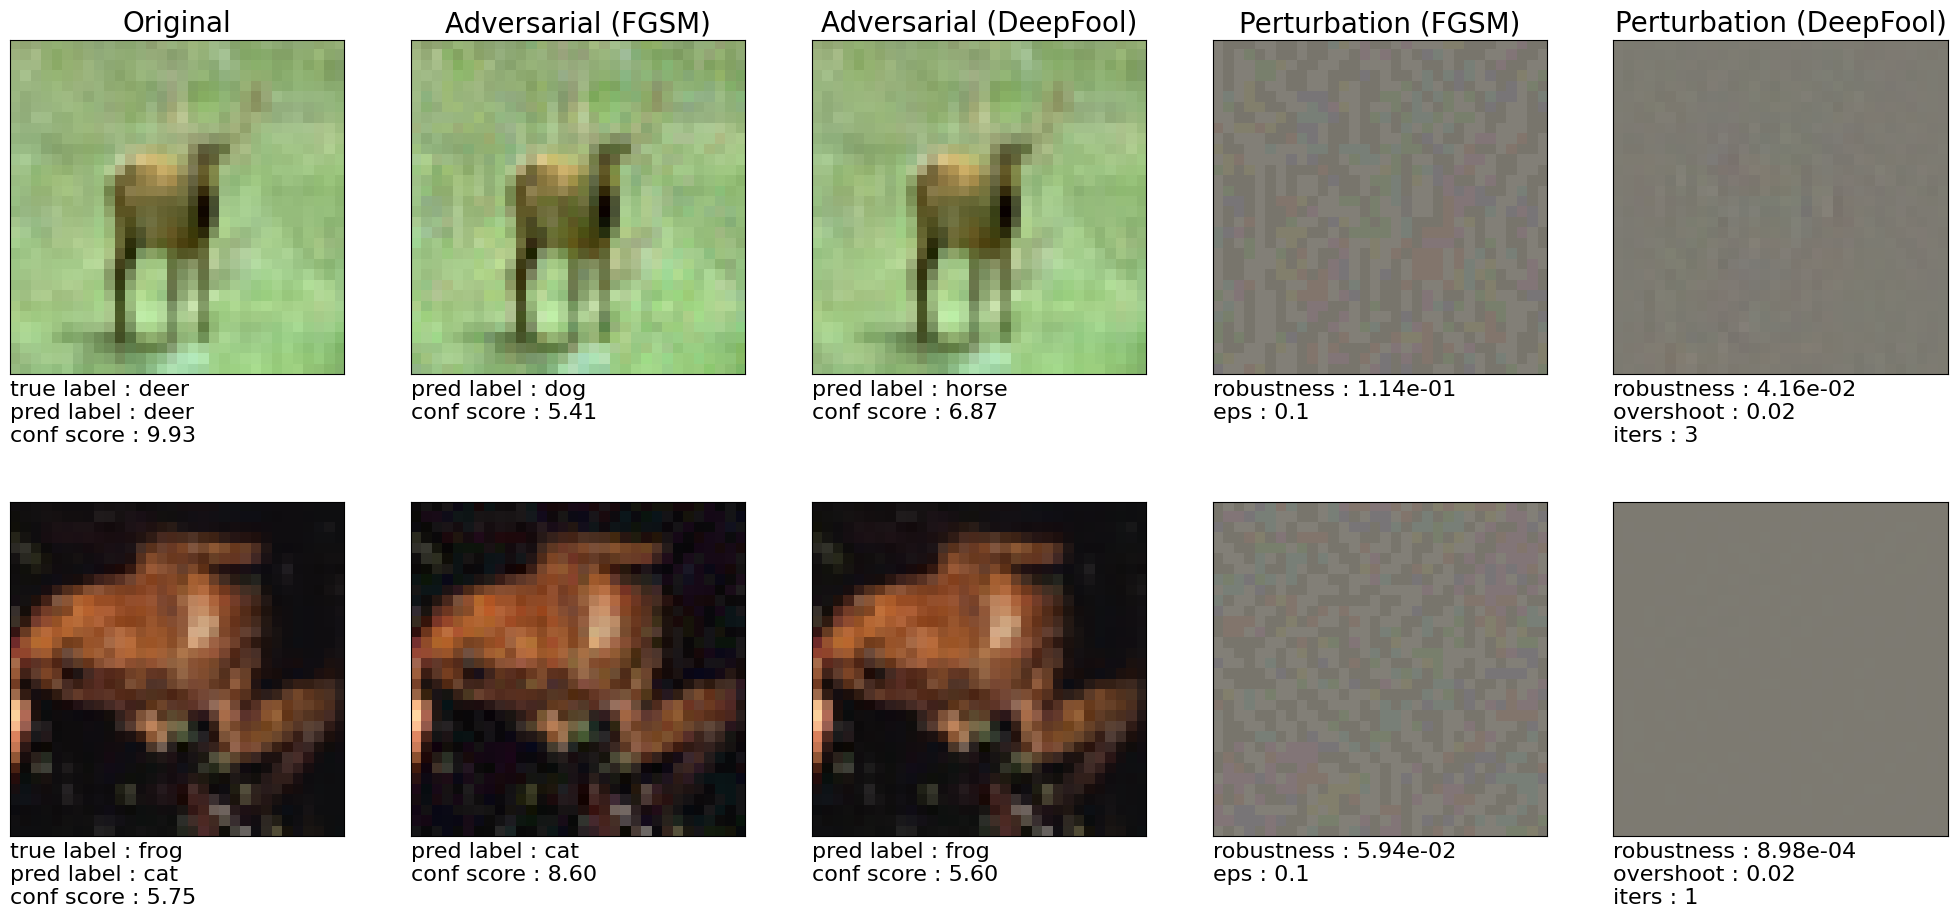

In [21]:

fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

Отразим отличия для fgsm_eps=(0.001, 0.02, 0.5, 0.9, 10) и выявим закономерность/обнаружим отсутсвие влияние параметра eps для сетей FC LeNet на датасете MNIST, NiN LeNEt на датасете CIFAR

Используется fgsm_eps 0.001


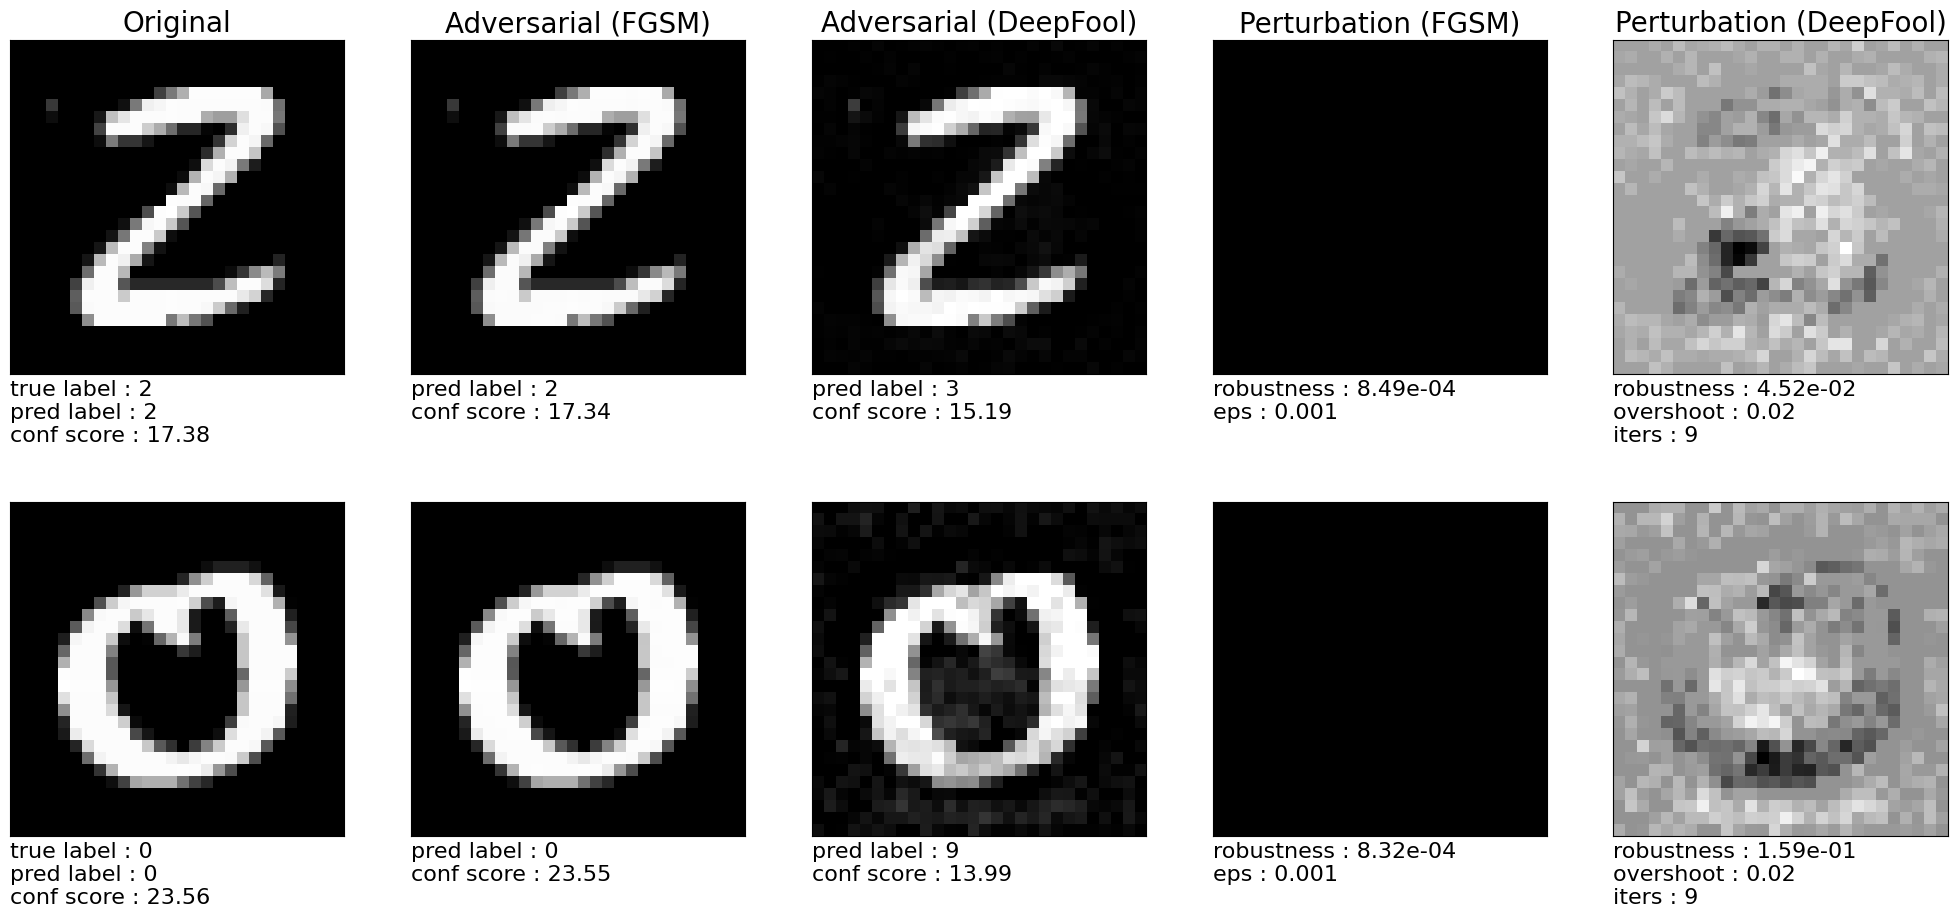

Используется fgsm_eps 0.02


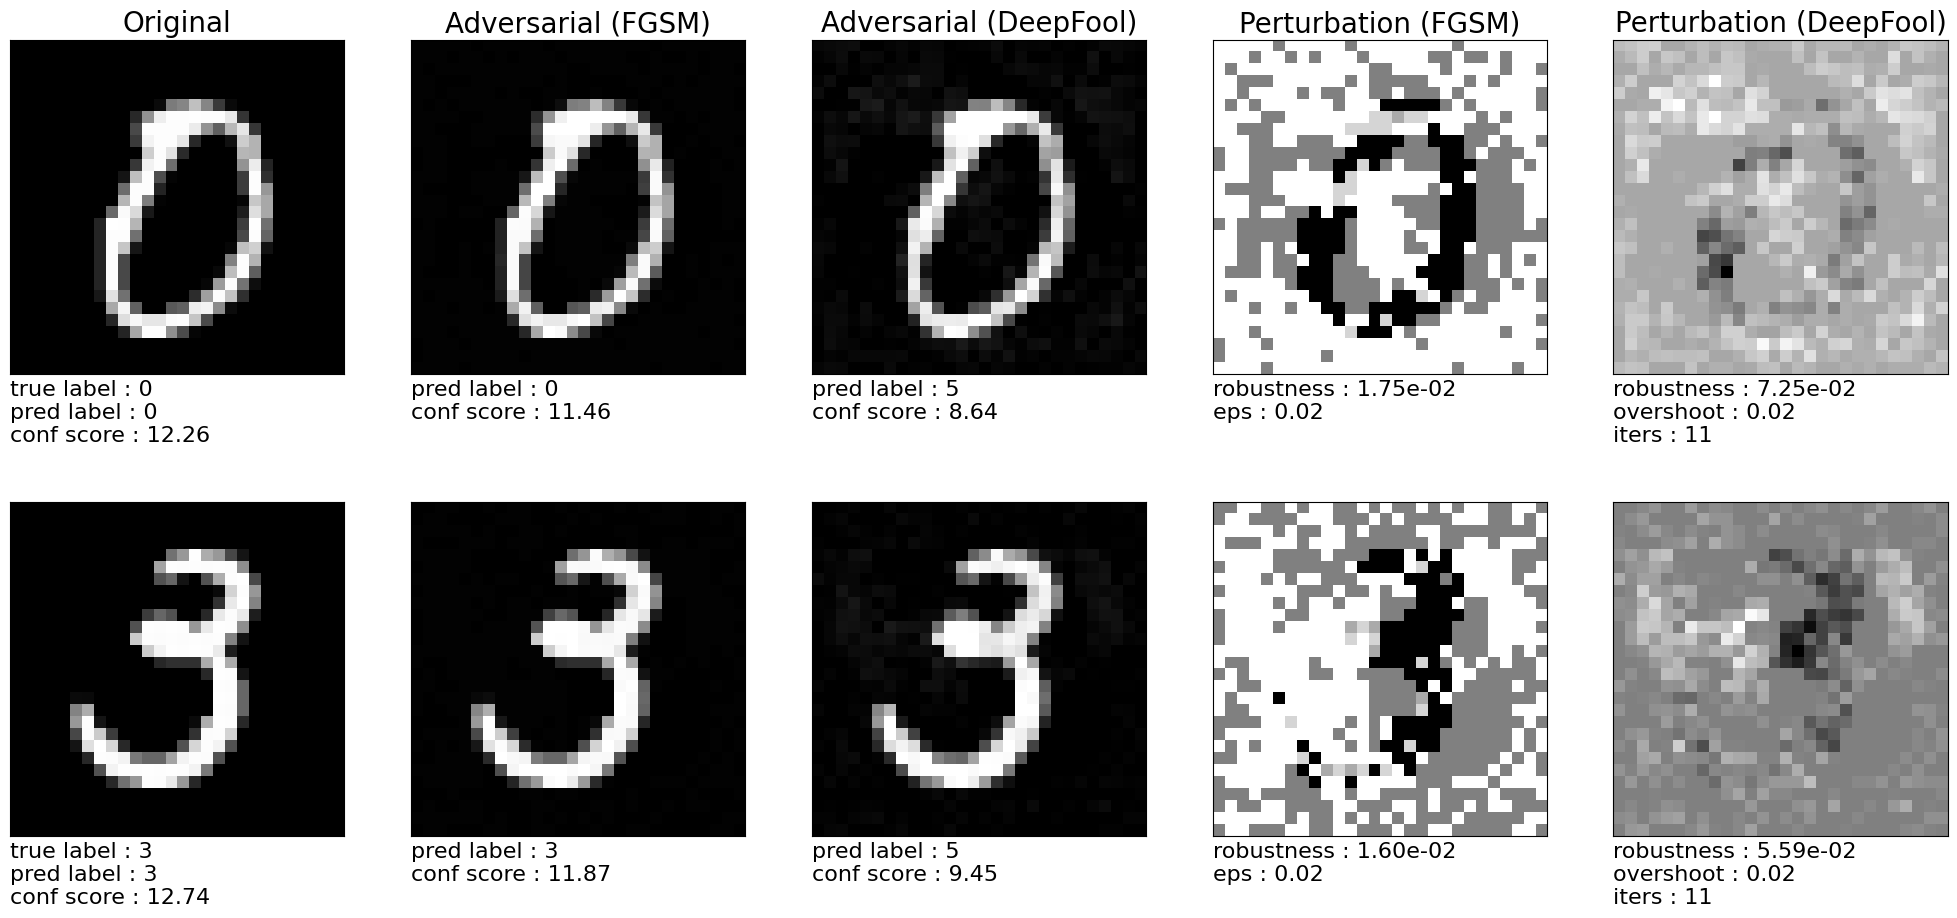

Используется fgsm_eps 0.5


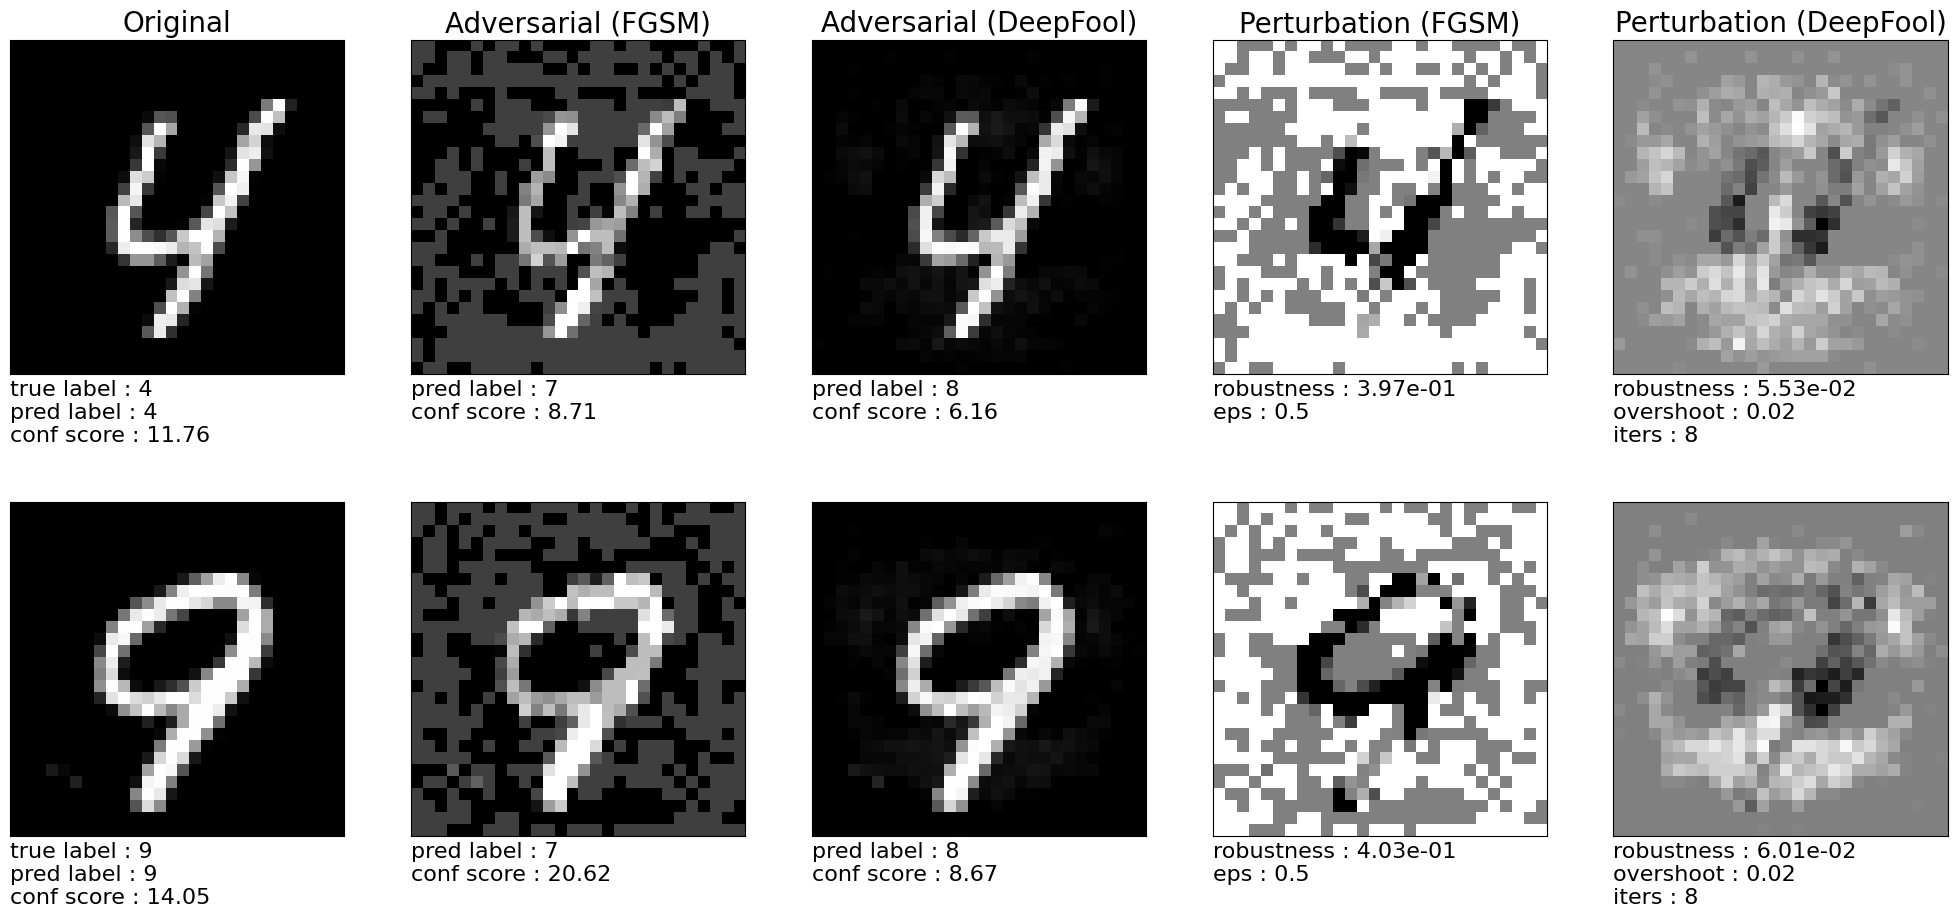

Используется fgsm_eps 0.9


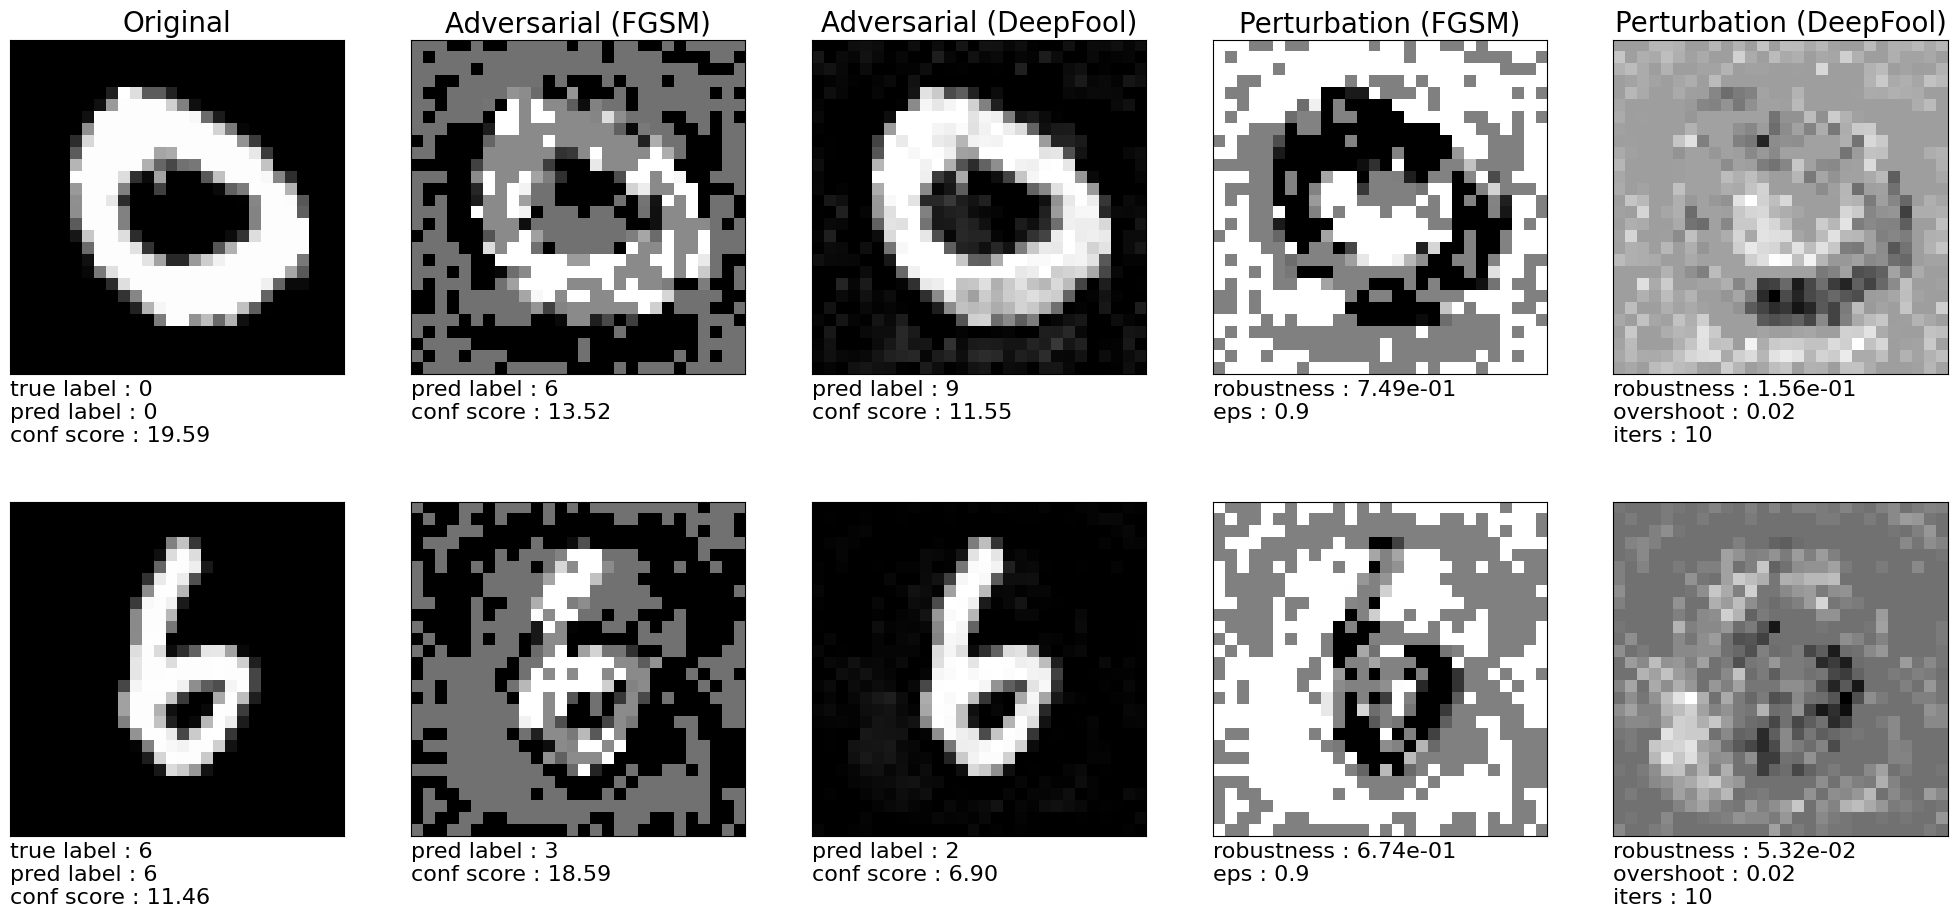

Используется fgsm_eps 10


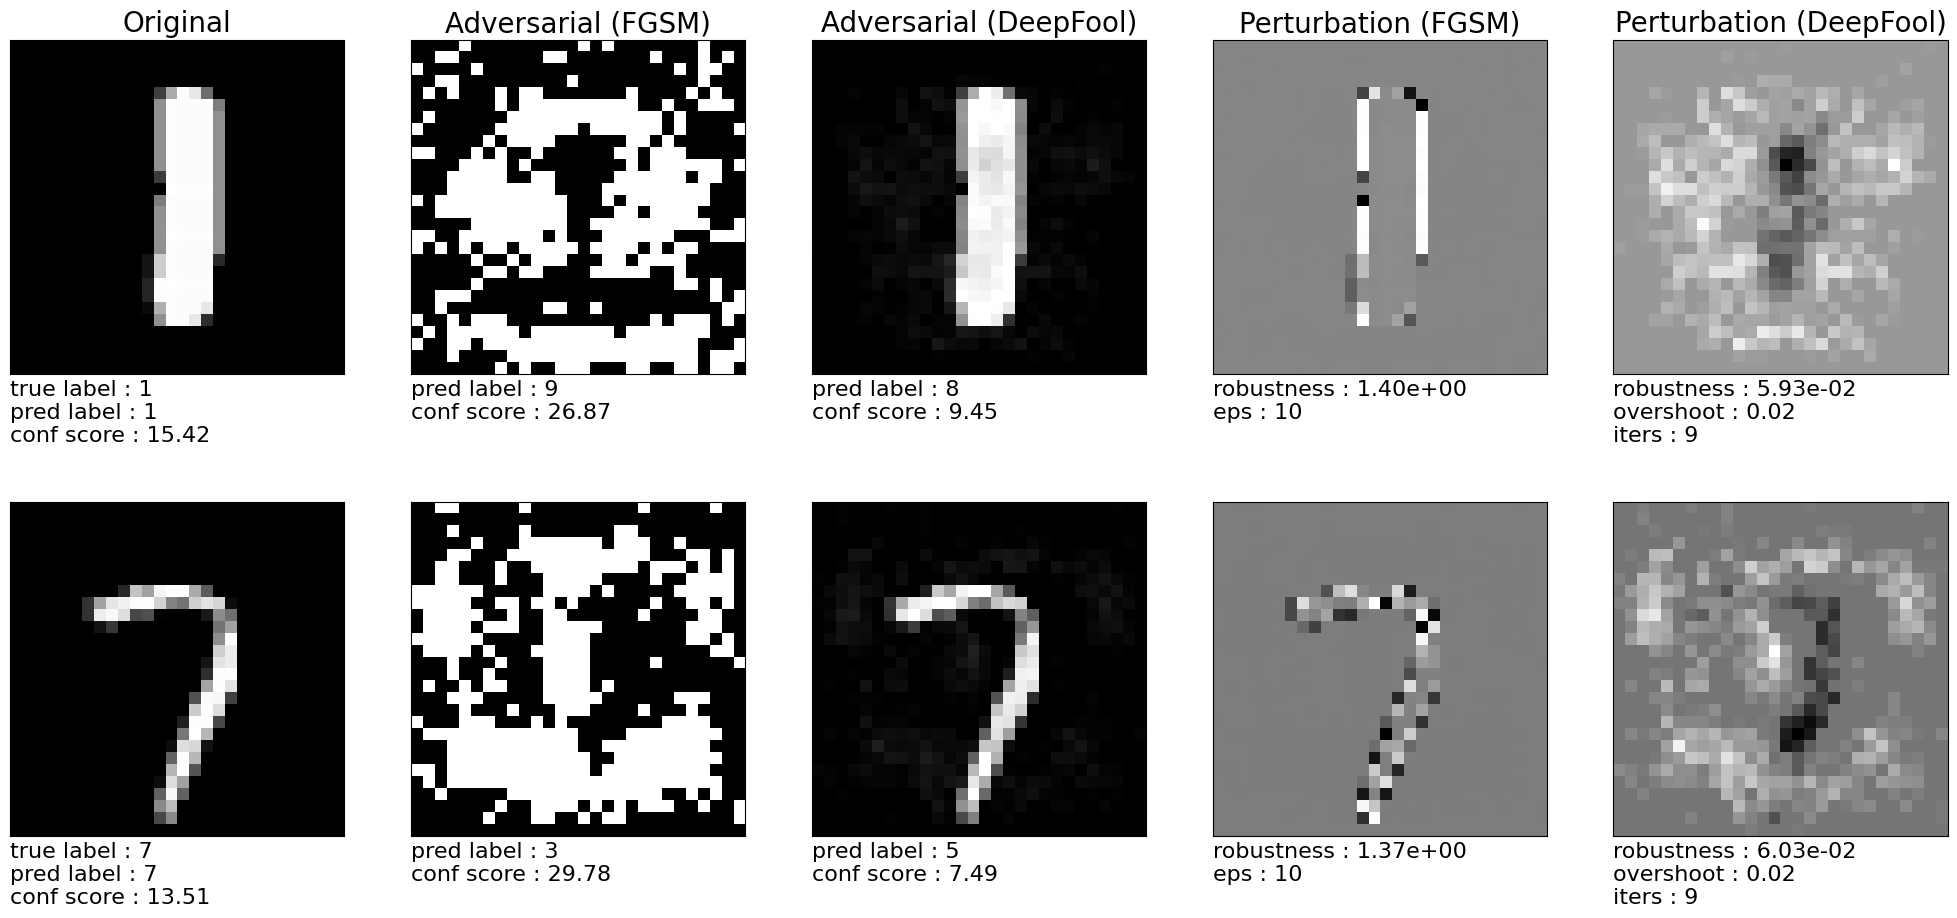

Используется fgsm_eps 0.001


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 3.07%
FGSM Robustness : 8.08e-04
FGSM Time (All Images) : 0.61 s
FGSM Time (Per Image) : 60.91 us
Используется fgsm_eps 0.02


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 5.54%
FGSM Robustness : 1.60e-02
FGSM Time (All Images) : 0.68 s
FGSM Time (Per Image) : 68.10 us
Используется fgsm_eps 0.5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.21%
FGSM Robustness : 3.86e-01
FGSM Time (All Images) : 0.54 s
FGSM Time (Per Image) : 54.31 us
Используется fgsm_eps 0.9


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.87%
FGSM Robustness : 6.86e-01
FGSM Time (All Images) : 0.66 s
FGSM Time (Per Image) : 66.32 us
Используется fgsm_eps 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.87%
FGSM Robustness : 1.47e+00
FGSM Time (All Images) : 0.88 s
FGSM Time (Per Image) : 87.81 us
Используется fgsm_eps 0.001


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


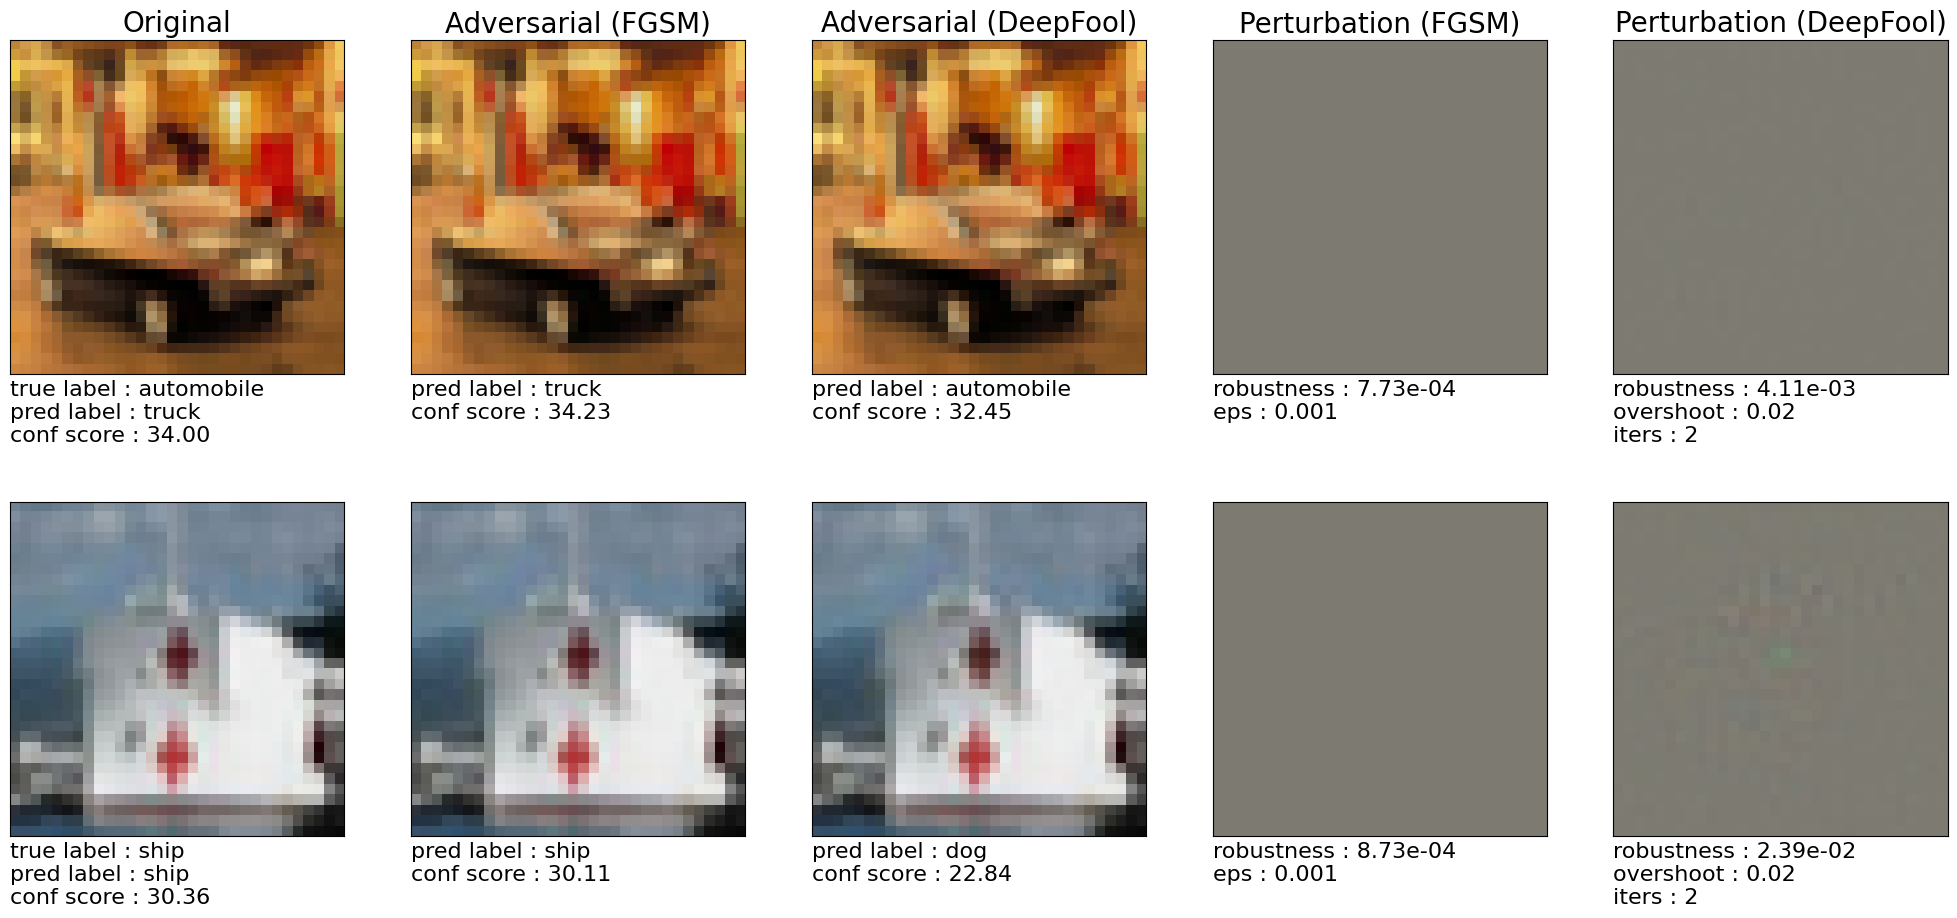

Используется fgsm_eps 0.02


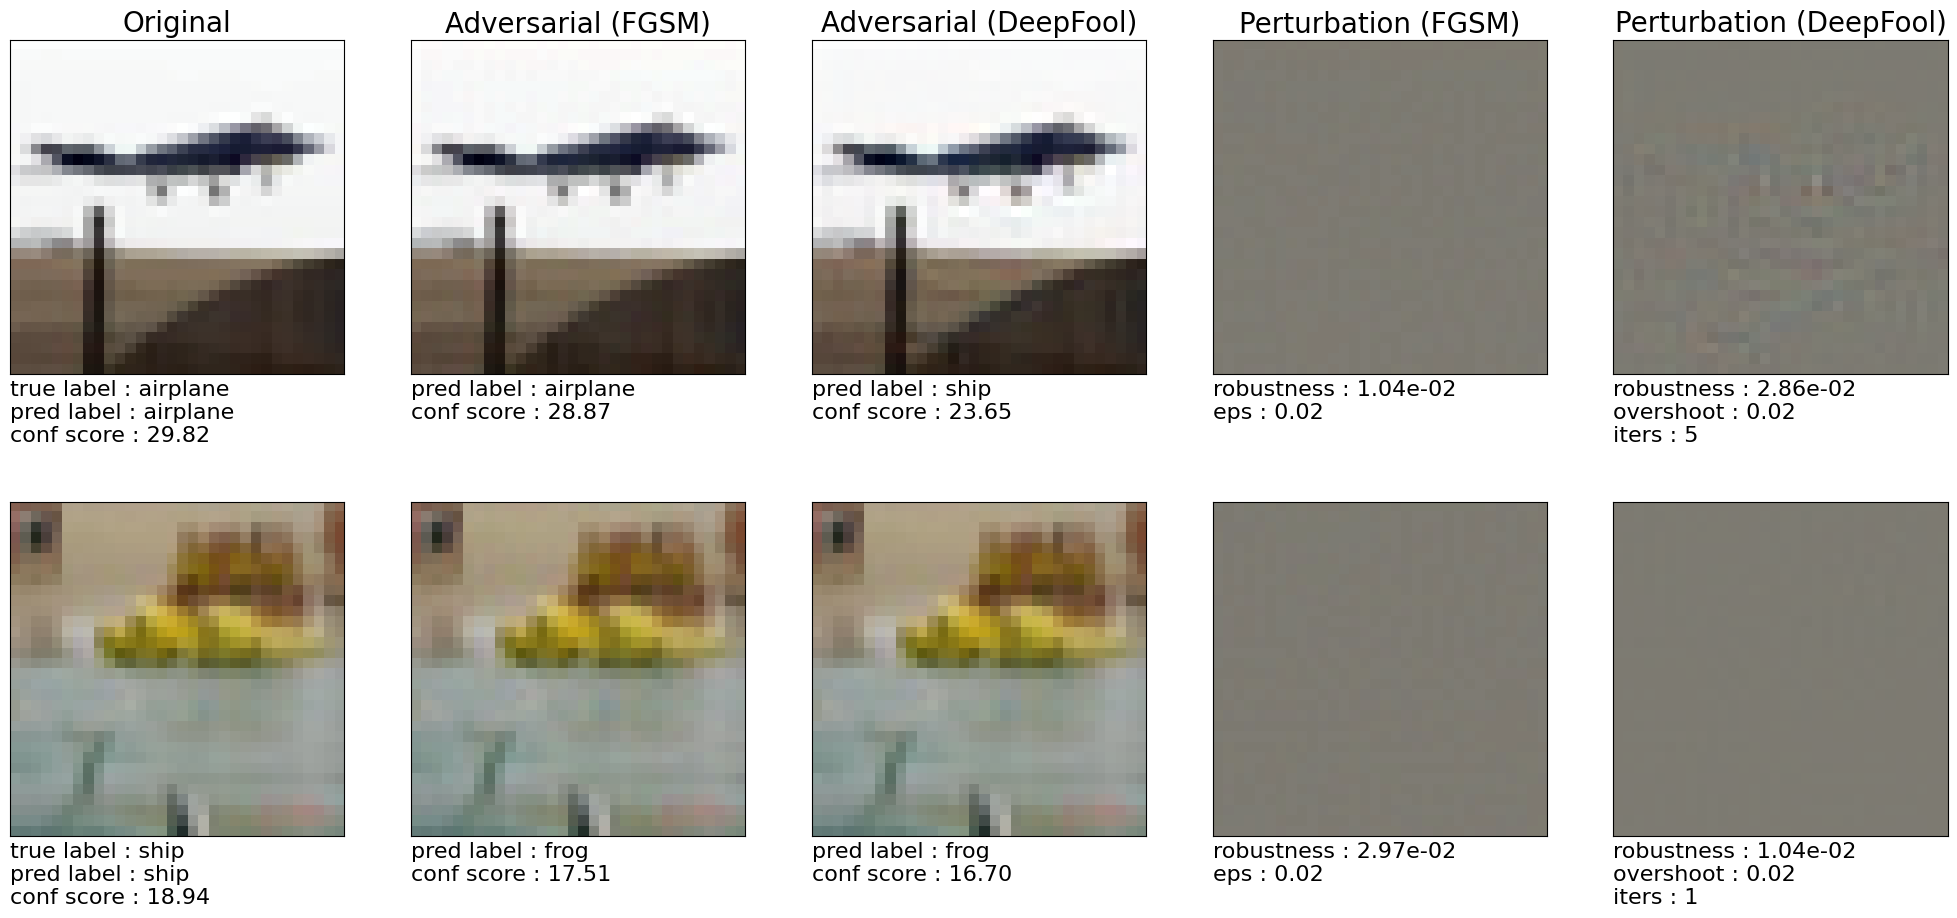

Используется fgsm_eps 0.5


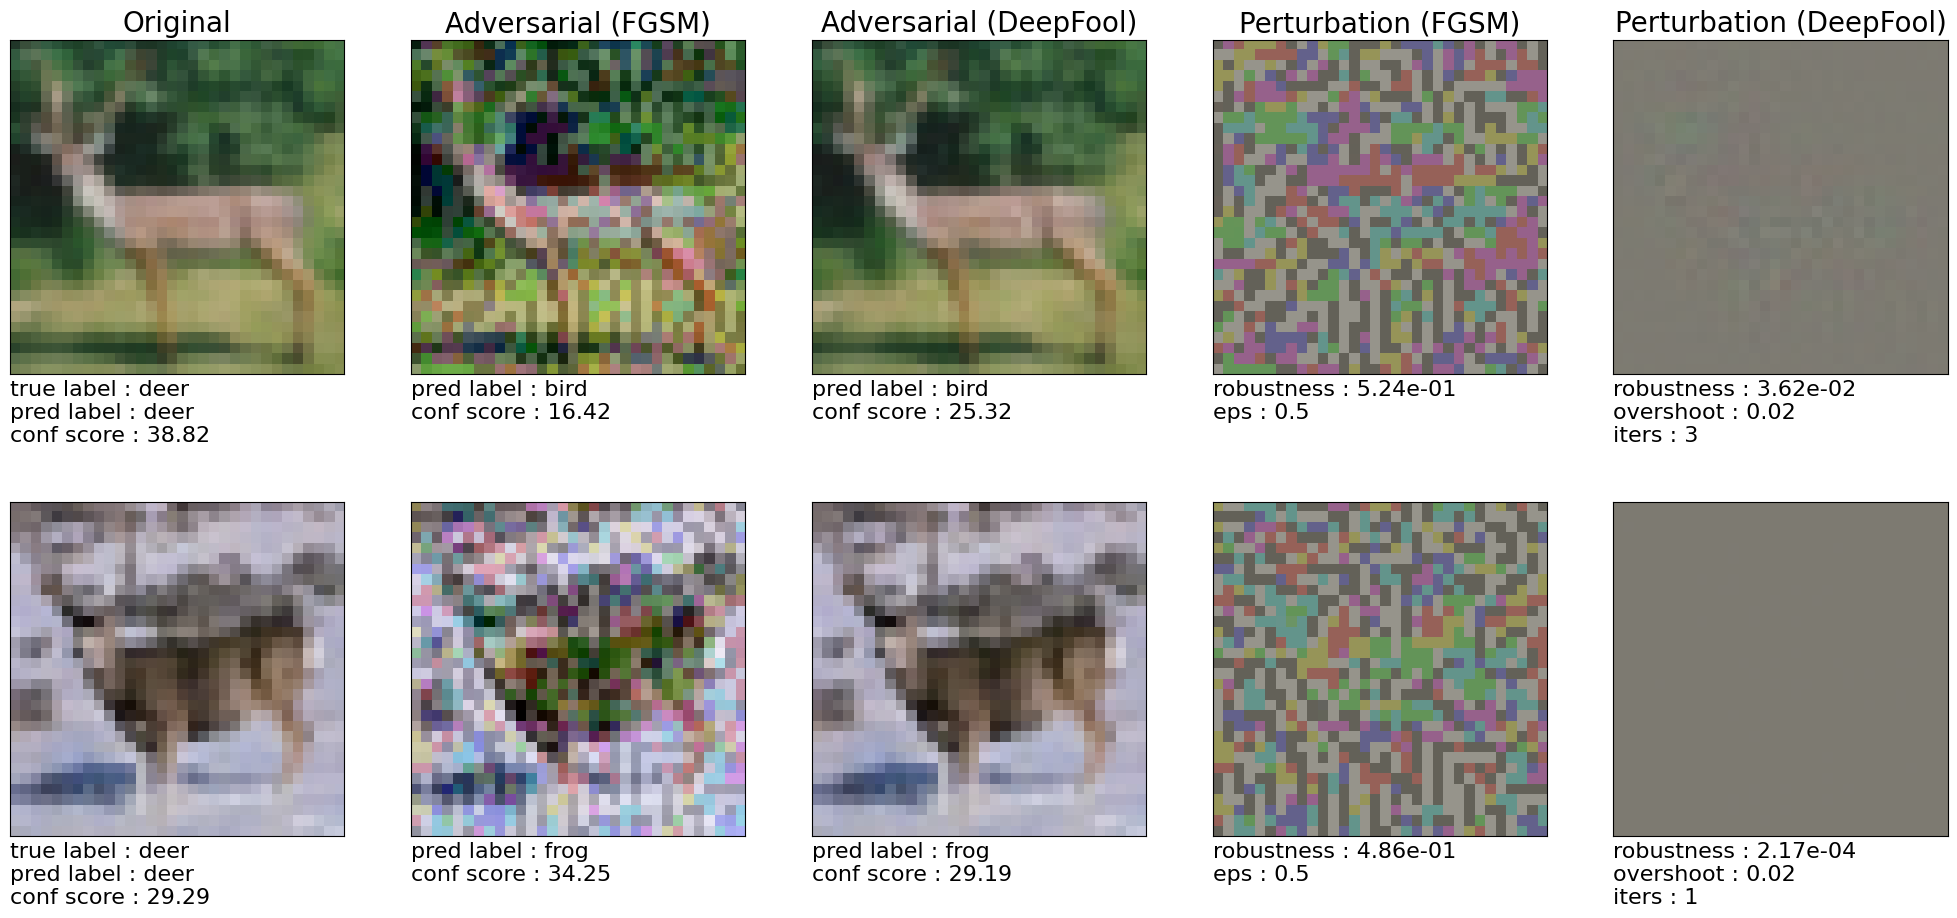

Используется fgsm_eps 0.9


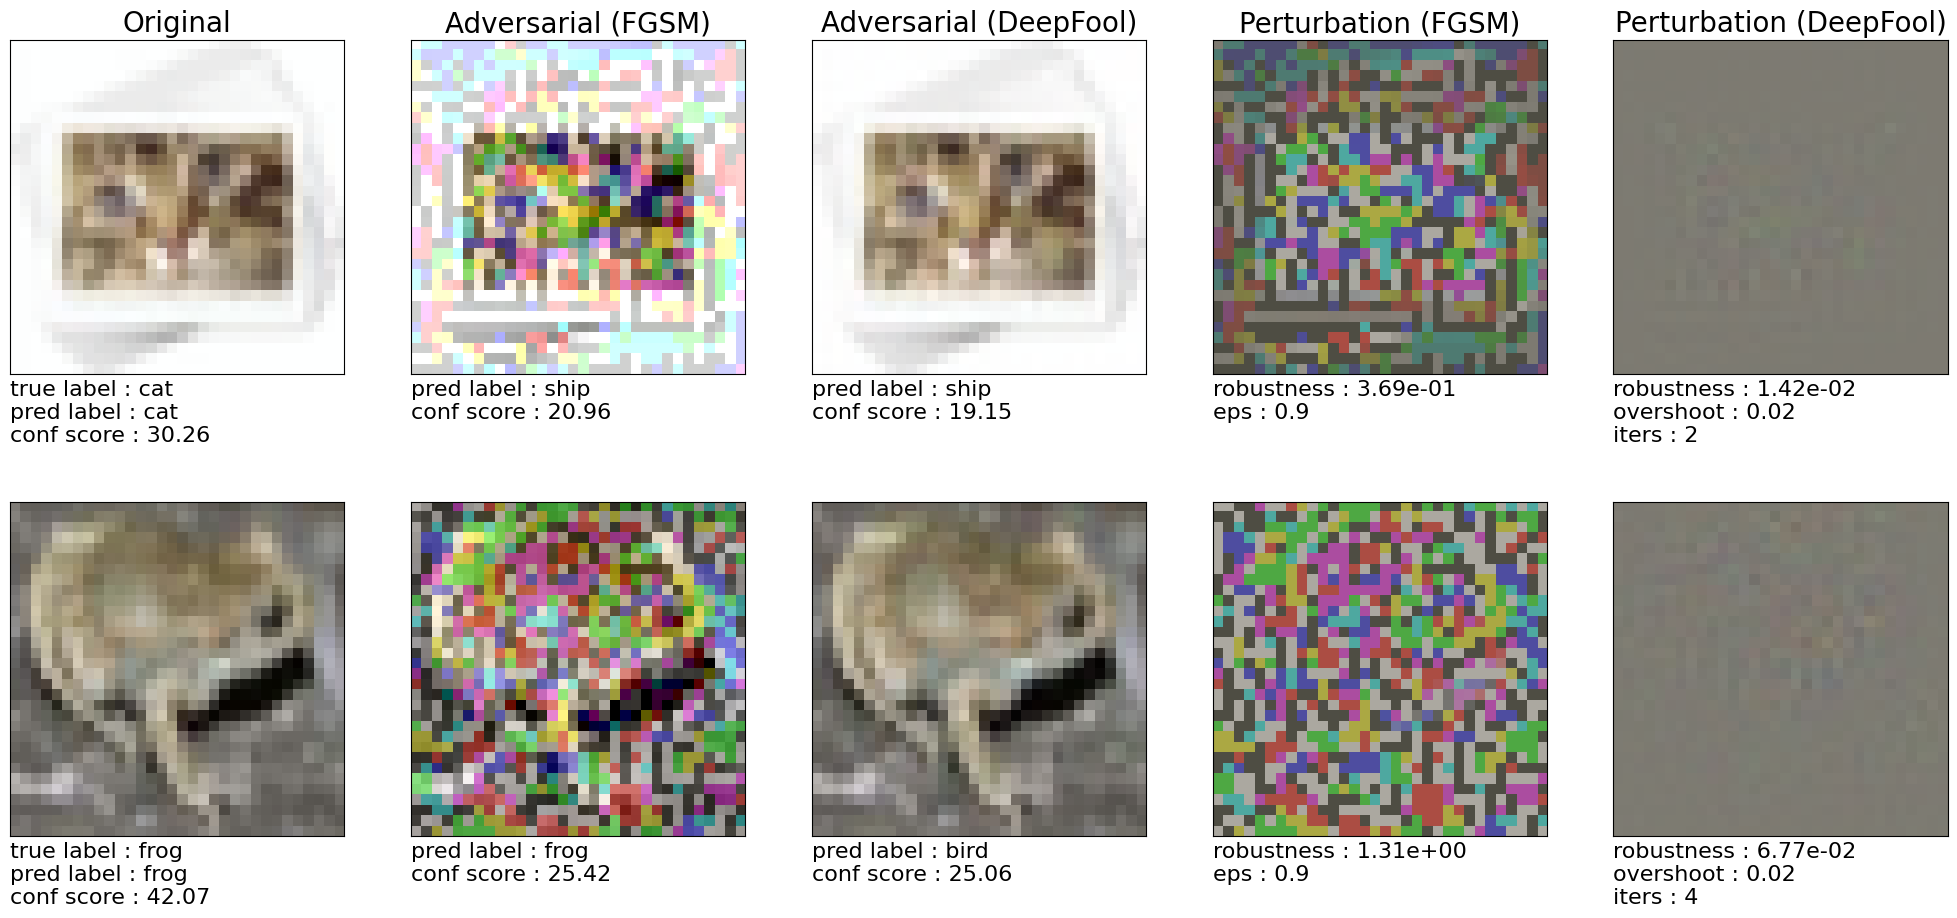

Используется fgsm_eps 10


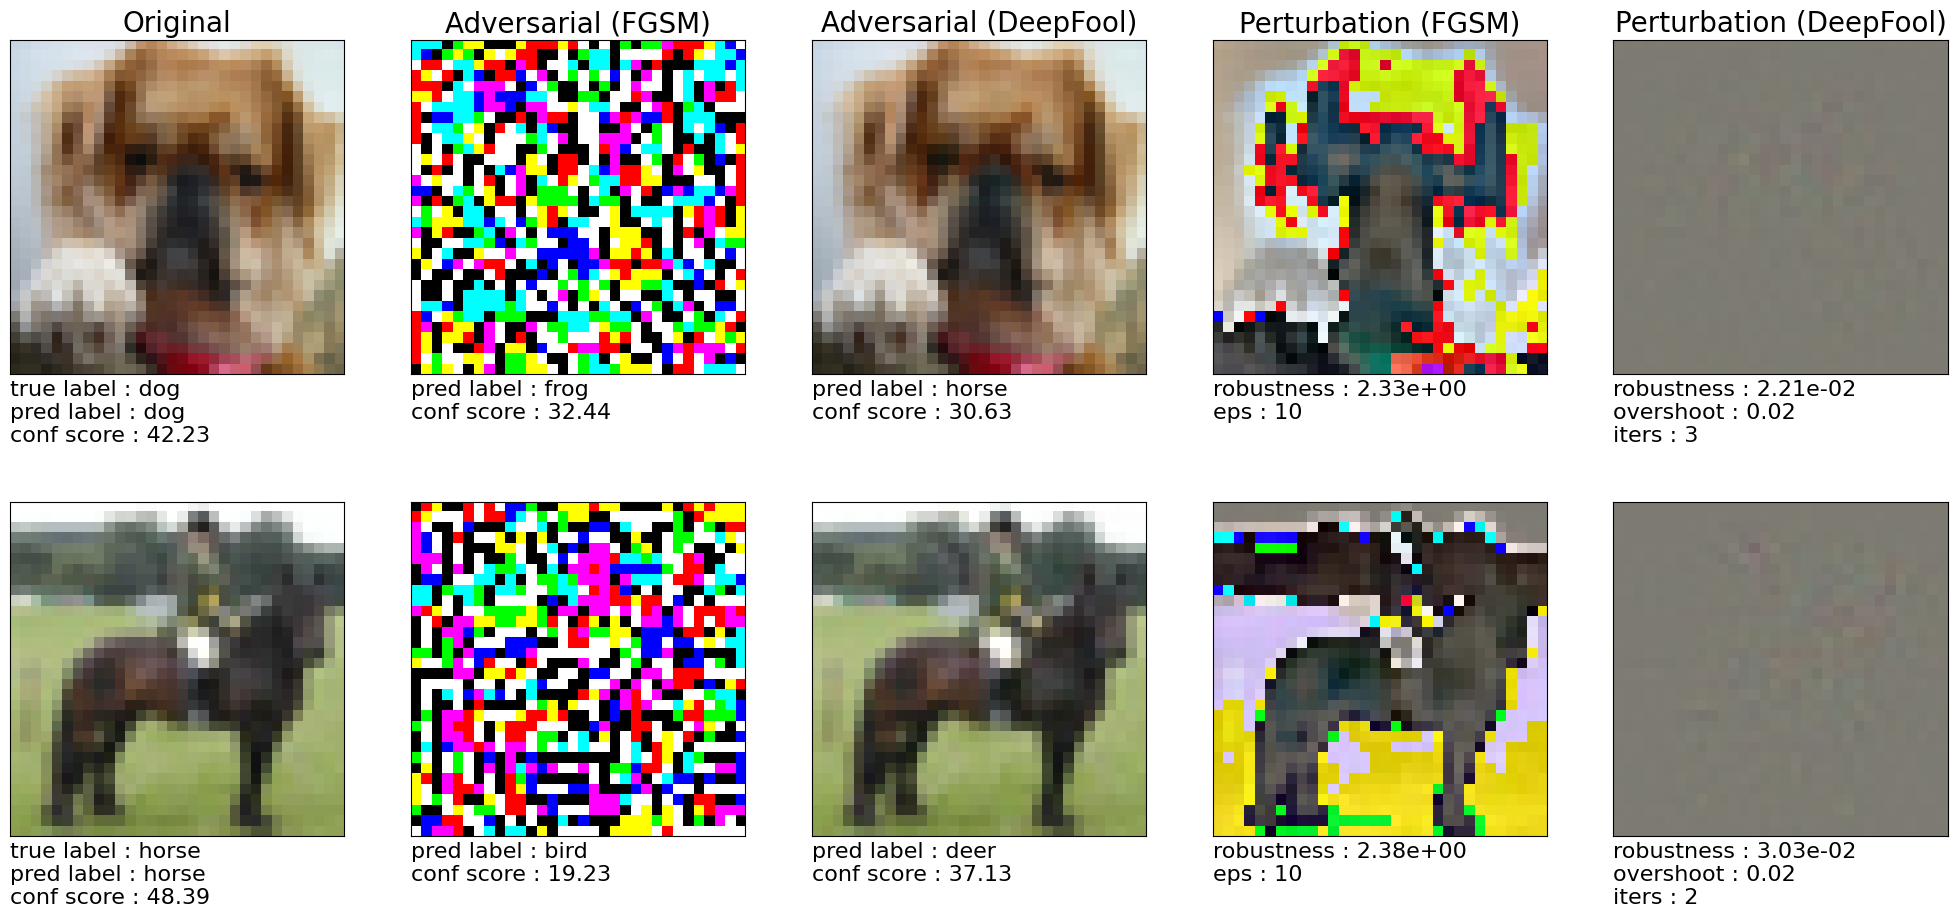

Используется fgsm_eps 0.001


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 10.12%
FGSM Robustness : 8.92e-04
FGSM Time (All Images) : 1.42 s
FGSM Time (Per Image) : 141.81 us
Используется fgsm_eps 0.02


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 30.76%
FGSM Robustness : 1.78e-02
FGSM Time (All Images) : 1.57 s
FGSM Time (Per Image) : 157.47 us
Используется fgsm_eps 0.5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 82.65%
FGSM Robustness : 4.40e-01
FGSM Time (All Images) : 1.59 s
FGSM Time (Per Image) : 158.88 us
Используется fgsm_eps 0.9


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 84.60%
FGSM Robustness : 7.79e-01
FGSM Time (All Images) : 1.66 s
FGSM Time (Per Image) : 165.61 us
Используется fgsm_eps 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 87.53%
FGSM Robustness : 2.46e+00
FGSM Time (All Images) : 1.42 s
FGSM Time (Per Image) : 141.82 us


In [22]:
fgsm_epss = [0.001, 0.02, 0.5, 0.9, 10]

for fgsm_eps in fgsm_epss:

    print(f"Используется fgsm_eps {fgsm_eps}")
    model = FC_500_150().to(device)
    model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

    display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

    if device.type == 'cuda': torch.cuda.empty_cache()

for fgsm_eps in fgsm_epss:

    print(f"Используется fgsm_eps {fgsm_eps}")
    model = FC_500_150().to(device)
    model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

    evaluate_attack(f'mnist_fc_fgsm_eps{fgsm_eps}.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)

    if device.type == 'cuda': torch.cuda.empty_cache()

for fgsm_eps in fgsm_epss:

    print(f"Используется fgsm_eps {fgsm_eps}")
    model = Net().to(device)
    model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

    display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

    if device.type == 'cuda': torch.cuda.empty_cache()

for fgsm_eps in fgsm_epss:

    print(f"Используется fgsm_eps {fgsm_eps}")
    model = Net().to(device)
    model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

    evaluate_attack(f'cifar_nin_fgsm_eps{fgsm_eps}.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)

    if device.type == 'cuda': torch.cuda.empty_cache()



Сравнение ошибки тестирования моделей

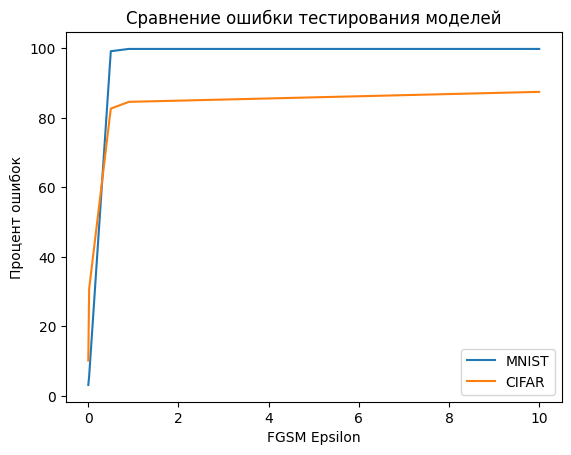

In [23]:
import matplotlib.pyplot as plt

fgsm_eps = [0.001, 0.02, 0.5, 0.9, 10]
fgsm_test_error_MNIST = [3.07, 5.54, 99.21, 99.87, 99.87]
fgsm_robustness_MNIST = [8.08e-04, 1.60e-02, 3.86e-01, 6.86e-01, 1.47e+00]
fgsm_test_error_CIFAR = [10.12, 30.76, 82.67, 84.62, 87.50]
fgsm_robustness_CIFAR = [8.92e-04, 1.78e-02, 4.40e-01, 7.79e-01, 2.46e+00]

plt.plot(fgsm_eps, fgsm_test_error_MNIST, label='MNIST')
plt.plot(fgsm_eps, fgsm_test_error_CIFAR, label='CIFAR')

plt.xlabel('FGSM Epsilon')
plt.ylabel('Процент ошибок')
plt.title('Сравнение ошибки тестирования моделей')
plt.legend()

plt.show()

Сравнение устойчивости модели

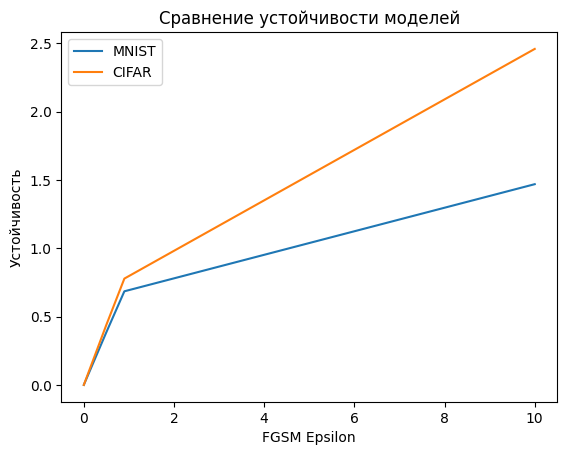

In [24]:

plt.plot(fgsm_eps, fgsm_robustness_MNIST, label='MNIST')
plt.plot(fgsm_eps, fgsm_robustness_CIFAR, label='CIFAR')

plt.xlabel('FGSM Epsilon')
plt.ylabel('Устойчивость')
plt.title('Сравнение устойчивости моделей')
plt.legend()

plt.show()

***Заключение***: по перебору значения eps для атак на модели можно с уверенностью сказать, что влияние есть.